In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [13]:
df = pd.read_csv('/content/drive/MyDrive/research/quora_duplicate_questions.csv')

df = df[['question1', 'question2', 'is_duplicate']]
df.dropna(inplace=True)

print(df.shape)
df.head()

(404348, 3)


,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [14]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['question1'] = df['question1'].apply(clean_text)
df['question2'] = df['question2'].apply(clean_text)


In [15]:
X = df[['question1', 'question2']]
y = df['is_duplicate']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [16]:
tfidf = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1,2)
)

X_train_tfidf = tfidf.fit_transform(
    X_train['question1'] + " " + X_train['question2']
)

X_test_tfidf = tfidf.transform(
    X_test['question1'] + " " + X_test['question2']
)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)

pred_lr = lr.predict(X_test_tfidf)

print("TF-IDF + Logistic Regression")
print("Accuracy:", accuracy_score(y_test, pred_lr))
print("F1 Score:", f1_score(y_test, pred_lr))


TF-IDF + Logistic Regression
Accuracy: 0.7825769753926054
F1 Score: 0.6760267536344039


In [17]:
!pip install -q sentence-transformers

In [18]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

sbert = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [19]:
q1_train_emb = sbert.encode(
    X_train['question1'].tolist(),
    batch_size=64,
    show_progress_bar=True
)

q2_train_emb = sbert.encode(
    X_train['question2'].tolist(),
    batch_size=64,
    show_progress_bar=True
)

X_train_sbert = np.hstack([
    q1_train_emb,
    q2_train_emb,
    np.abs(q1_train_emb - q2_train_emb)
])


Batches:   0%|          | 0/5055 [00:00<?, ?it/s]

Batches:   0%|          | 0/5055 [00:00<?, ?it/s]

In [20]:
lr_sbert = LogisticRegression(max_iter=1000)
lr_sbert.fit(X_train_sbert, y_train)

LogisticRegression(max_iter=1000)

In [21]:
q1_test_emb = sbert.encode(
    X_test['question1'].tolist(),
    batch_size=64,
    show_progress_bar=True
)

q2_test_emb = sbert.encode(
    X_test['question2'].tolist(),
    batch_size=64,
    show_progress_bar=True
)

X_test_sbert = np.hstack([
    q1_test_emb,
    q2_test_emb,
    np.abs(q1_test_emb - q2_test_emb)
])

pred_sbert = lr_sbert.predict(X_test_sbert)

print("SBERT + Logistic Regression")
print("Accuracy:", accuracy_score(y_test, pred_sbert))
print("F1 Score:", f1_score(y_test, pred_sbert))


Batches:   0%|          | 0/1264 [00:00<?, ?it/s]

Batches:   0%|          | 0/1264 [00:00<?, ?it/s]

SBERT + Logistic Regression
Accuracy: 0.8278842586867813
F1 Score: 0.7653534280753216


In [22]:
error_df = X_test.copy()
error_df['true_label'] = y_test.values
error_df['predicted'] = pred_sbert

errors = error_df[error_df['true_label'] != error_df['predicted']]
errors.sample(20)


,question1,question2,true_label,predicted
28489,are all the stars we see in the sky part of th...,would the night sky look different to the casu...,1,0
214696,what is the difference between cse and softwar...,what is the difference between cse it and soft...,0,1
369491,why is earthing important,what is the importance of earthing,0,1
4921,how can i cure vitiligo,i have vitiligo is there any cure for it or is...,1,0
289342,what powers do the president and prime ministe...,why is the prime minister more powerful in ind...,1,0
397732,who makes the final decision on which question...,how does quora decide on which answers to send...,1,0
65523,what is demonetization in india,when did demonetization occur in india,0,1
341345,how do i find a girlfriend,how do i find my girlfriend a girlfriend,0,1
345614,should i learn scala just for spark programming,what is the fastest way to learn enough scala ...,0,1
348830,what are the primary defects of,what are the primary design defects of,1,0


In [25]:
errors.to_csv('/content/drive/MyDrive/research/sbert_errors.csv', index=False)

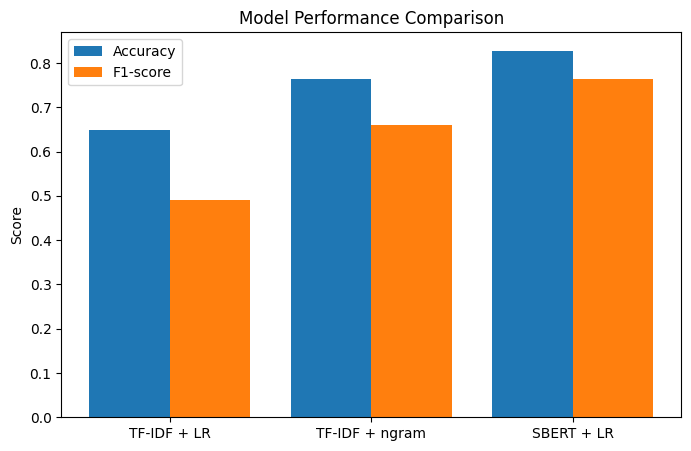

In [26]:
import matplotlib.pyplot as plt

models = ['TF-IDF + LR', 'TF-IDF + ngram', 'SBERT + LR']
accuracy = [0.649, 0.763, 0.828]
f1 = [0.49, 0.66, 0.765]

x = range(len(models))

plt.figure(figsize=(8,5))
plt.bar(x, accuracy, width=0.4, label='Accuracy')
plt.bar([i+0.4 for i in x], f1, width=0.4, label='F1-score')

plt.xticks([i+0.2 for i in x], models)
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()


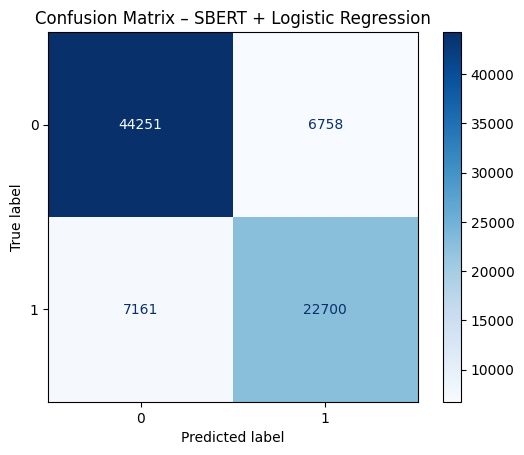

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred_sbert)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix – SBERT + Logistic Regression")
plt.show()

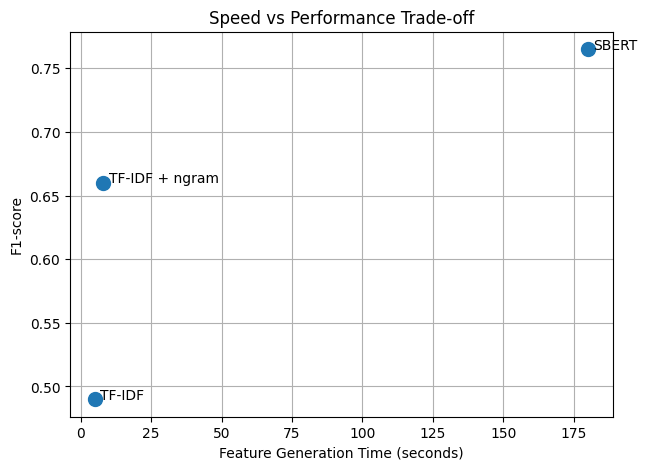

In [29]:
models = ['TF-IDF', 'TF-IDF + ngram', 'SBERT']
f1_scores = [0.49, 0.66, 0.765]
time_seconds = [5, 8, 180]  # approximate / measured times

plt.figure(figsize=(7,5))
plt.scatter(time_seconds, f1_scores, s=100)

for i, model in enumerate(models):
    plt.annotate(model, (time_seconds[i]+2, f1_scores[i]))

plt.xlabel('Feature Generation Time (seconds)')
plt.ylabel('F1-score')
plt.title('Speed vs Performance Trade-off')
plt.grid(True)
plt.show()


In [30]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=05d6492dff28e093ccf492cde2f89c638b3e0d213a937ce942cb2a22d42b811f
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [32]:
import numpy as np

def sbert_predict(texts):
    q1 = []
    q2 = []

    for t in texts:
        parts = t.split("|||")
        q1.append(parts[0].strip())
        q2.append(parts[1].strip())

    # Encode correctly (list of strings is expected)
    emb1 = model.encode(q1, convert_to_numpy=True)
    emb2 = model.encode(q2, convert_to_numpy=True)

    cosine_sim = np.sum(emb1 * emb2, axis=1) / (
        np.linalg.norm(emb1, axis=1) * np.linalg.norm(emb2, axis=1)
    )

    return clf_sbert.predict_proba(cosine_sim.reshape(-1, 1))


In [33]:
!pip install shap

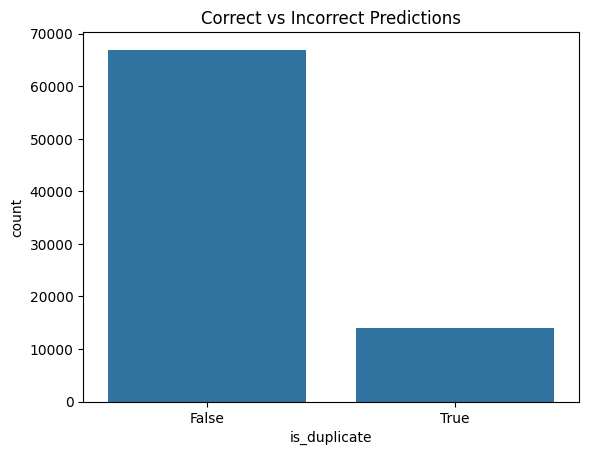

In [38]:
import seaborn as sns

errors = y_test != pred_sbert
sns.countplot(x=errors)
plt.title("Correct vs Incorrect Predictions")
plt.show()


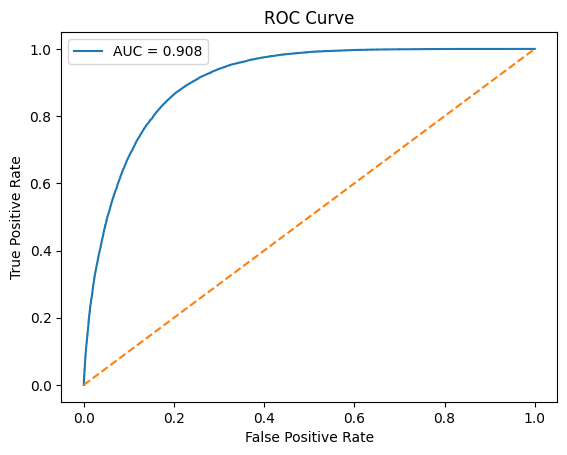

In [46]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = lr_sbert.predict_proba(X_test_sbert)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


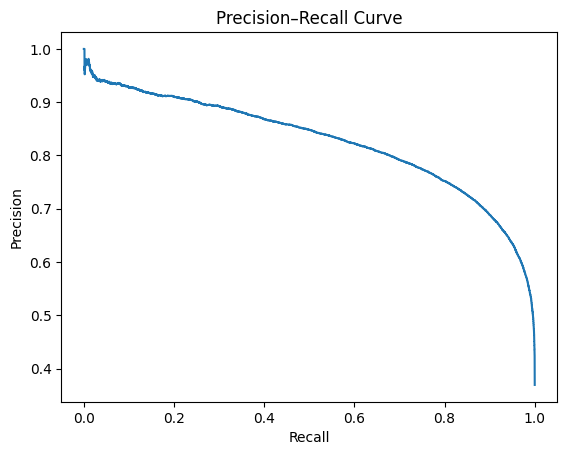

In [47]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()


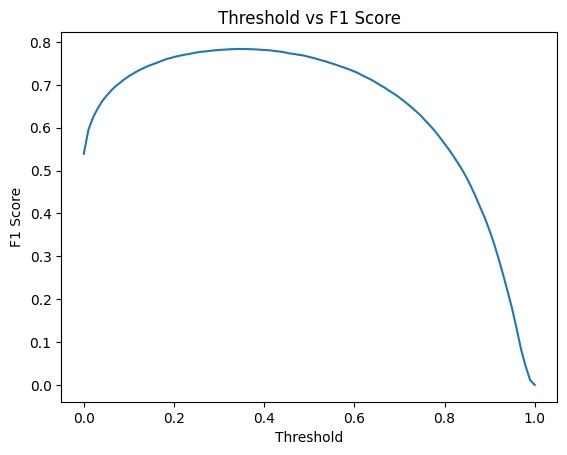

In [48]:
thresholds = np.linspace(0, 1, 100)
f1_scores = []

for t in thresholds:
    preds = (y_prob >= t).astype(int)
    f1_scores.append(f1_score(y_test, preds))

plt.figure()
plt.plot(thresholds, f1_scores)
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("Threshold vs F1 Score")
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


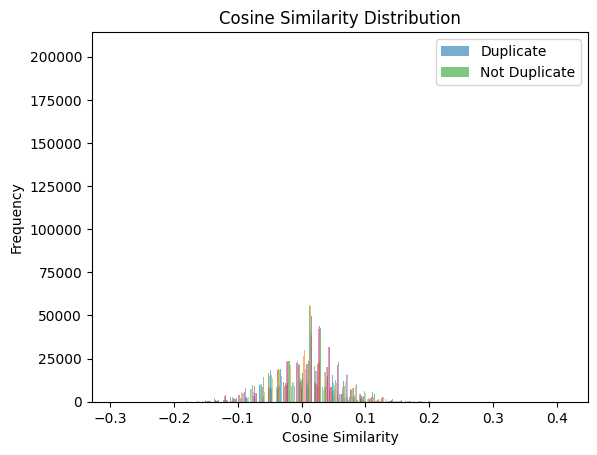

In [51]:
import matplotlib.pyplot as plt

plt.hist(X_train_sbert[y_train == 1], bins=50, alpha=0.6, label="Duplicate")
plt.hist(X_train_sbert[y_train == 0], bins=50, alpha=0.6, label="Not Duplicate")
plt.legend()
plt.title("Cosine Similarity Distribution")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()


In [54]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean

def build_features(emb1, emb2, q1_texts, q2_texts):
    features = []

    for i in range(len(emb1)):
        cos = cosine_similarity(
            emb1[i].reshape(1,-1),
            emb2[i].reshape(1,-1)
        )[0][0]

        l2 = euclidean(emb1[i], emb2[i])

        abs_diff = np.abs(emb1[i] - emb2[i]).mean()
        prod = (emb1[i] * emb2[i]).mean()

        len_ratio = len(q1_texts[i]) / max(1, len(q2_texts[i]))

        features.append([cos, l2, abs_diff, prod, len_ratio])

    return np.array(features)


In [55]:
X_train_feat = build_features(
    q1_train_emb,
    q2_train_emb,
    X_train["question1"].tolist(),
    X_train["question2"].tolist()
)

X_test_feat = build_features(
    q1_test_emb,
    q2_test_emb,
    X_test["question1"].tolist(),
    X_test["question2"].tolist()
)


In [56]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train_feat, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [57]:
from sklearn.metrics import accuracy_score, f1_score

y_pred = xgb.predict(X_test_feat)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))


Accuracy: 0.786187708668233
F1: 0.7173518594196976


In [58]:
y_probs = xgb.predict_proba(X_test_feat)[:,1]

best_f1 = 0
best_t = 0.5

for t in np.arange(0.3, 0.7, 0.01):
    preds = (y_probs >= t).astype(int)
    f1 = f1_score(y_test, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print("Best threshold:", best_t)
print("Best F1:", best_f1)


Best threshold: 0.36000000000000004
Best F1: 0.7398059072918574
